In [1]:
def jaccard_sim(a,b):
    a = set(a)
    b = set(b)
    return len(a&b) / len(a|b) # |A intersection B| / |A union B|

In [2]:
# Specify the path to your text file
file_path = "data\data.txt" 
sets = [] # Array to store all sets

try:
    with open(file_path, 'r') as file:
        # Iterate over each line in the file

        for line in file:
            sets.append(set(line.strip().split(" ")))

except FileNotFoundError:
    print(f"Error: The file '{file_path}' was not found.")
except Exception as e:
    print(f"An error occurred: {e}")

In [3]:
# Sample 5000 sets and compute their pairwise Jaccard similarities
import random
import time
import math

sampled_indices = random.sample(range(len(sets)), 5000)

count = 0
total_time = 0
data = []

for i in range(len(sampled_indices)):
    for j in range(i+1, len(sampled_indices)):
        start = time.perf_counter()
        jac_sim = jaccard_sim(sets[sampled_indices[i]], sets[sampled_indices[j]])
        data.append(jac_sim)
        end = time.perf_counter()
        total_time += end - start
        count += 1

avg_time = total_time / count
print(f"Average time it took to calculate Jaacard Similiarity: {avg_time}")

n = len(sets)
total_estimated_time = avg_time * math.comb(n, 2)
print(f"Total estimated time to compute Jaccard Similarity of each of the pairs: {total_estimated_time}")

Average time it took to calculate Jaacard Similiarity: 1.1023659211834689e-05
Total estimated time to compute Jaccard Similarity of each of the pairs: 5511824.094087739


(array([4.575800e+04, 9.011540e+05, 3.343699e+06, 4.421149e+06,
        2.718160e+06, 8.818540e+05, 1.640830e+05, 1.993100e+04,
        1.615000e+03, 9.700000e+01]),
 array([0.        , 0.01509434, 0.03018868, 0.04528302, 0.06037736,
        0.0754717 , 0.09056604, 0.10566038, 0.12075472, 0.13584906,
        0.1509434 ]),
 <BarContainer object of 10 artists>)

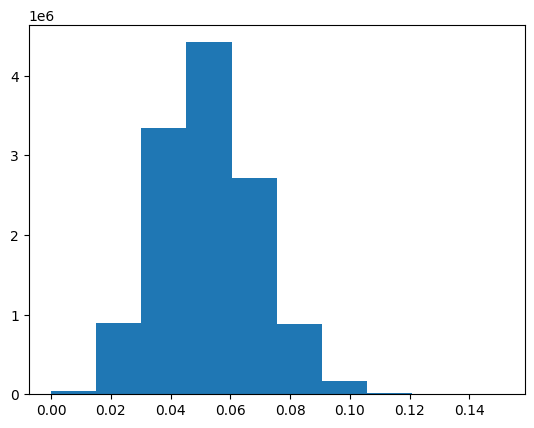

In [4]:
import matplotlib.pyplot as plt

#Plot histogram of the data
plt.hist(data)

In [5]:
#s-curve equation for LSE

def s_curve(s, r, b):
    return 1-(1-s**r)**b

#Case1: let r=5 and b=20, as shown in the slides.
#We want s=0.85 to be highly likely to result in a collision, while similarities < 0.85 to result in low probability
#We can calculate the expected value of the candidate pairs, and check how much time to compute the similarity within
#the pairs.
def check_rb(r, b):
    print(f"Probability that s = 0.85 results in a collision: {s_curve(s = 0.85, r=r, b=b)}")

    expected_fp = 0
    expected_tp = 0

    for sim in data:
        if sim < 0.85:
            expected_fp += s_curve(s = sim, r=r, b=b)
        else:
            expected_tp += s_curve(s = sim, r=r, b=b)

    expected_total = expected_fp + expected_tp

    #We can translate this result to the whole data
    num_total_pairs = math.comb(n, 2)
    num_pairs_5000 = len(data)
    expected_total_dataset = (num_total_pairs / num_pairs_5000) * expected_total
    add_time_check = avg_time * expected_total_dataset

    print(f"Expected number of false positives when r = {r}, b = {b} (based on 5000 sample): {(num_total_pairs / num_pairs_5000) * expected_fp}")
    print(f"Expected number of candidates = {expected_total_dataset}")
    print(f"Additional time to check the candidates = {add_time_check} seconds")

print("r = 10, b = 10")
check_rb(10, 10)

print("r = 5, b = 20")
check_rb(5, 20)

r = 10, b = 10
Probability that s = 0.85 results in a collision: 0.8883561842922729
Expected number of false positives when r = 10, b = 10 (based on 5000 sample): 15.435545549607689
Expected number of candidates = 15.435545549607689
Additional time to check the candidates = 0.00017015619388762674 seconds
r = 5, b = 20
Probability that s = 0.85 results in a collision: 0.9999919443933685
Expected number of false positives when r = 5, b = 20 (based on 5000 sample): 8781892.31247845
Expected number of candidates = 8781892.31247845
Additional time to check the candidates = 96.8085880877933 seconds


Based on my analysis, I decided to choose r = 10 and b = 10. According to the analysis, the probability that s = 0.85 results in a collision is near 89 percent (calculated based on s-curve equation). Also, using the 5000 sample data, I've calculated the estimated number of false positives/candidates, which was only 15!. And expected additional time to check the candidates is only 0.00017 seconds, which is extremely fast. I've tried other combination r = 5 and b = 20. Although this resulted in an extremely high probability of collition when s = 0.85 (99.99 percent!), there were too many candidate pairs (8,700,000), which only takes 98 additional seconds, but will cause memory errors. 

In [6]:
pip install mmh3

Note: you may need to restart the kernel to use updated packages.


In [7]:
#Use minhashing technique described in paper.

#1. create a hash value for each set using murmurhash3
import mmh3

#2. Hash element of a set, place them to their bucket by getting remainder (%100 since 100 buckets).
signatures = []

for cur_set in sets:
    signature = [float('inf') for _ in range(100)] #100 buckets for signature

    for elem in cur_set:
        hash = mmh3.hash(elem, signed = False)
        signature[hash%100] = min(signature[hash%100], hash)
    
    signatures.append(signature)

In [ ]:
# Now, with r = 10 and b = 10, place the similar sets together.
import itertools

candidate_pairs = set()
r, b = 10, 10

for band_index in range(b):
    buckets = {}
    for i, signature in enumerate(signatures): #the index of signatures is the same as index of sets
        band = signature[(band_index*r): (band_index*r)+r]

        if band == [float('inf')] * r:
            continue  #skipping meaningless bands
    
        band = tuple(band)

        if band not in buckets:
            buckets[band] = [i]
        else:
            buckets[band].append(i)
    
    for bucket in buckets.values():
        if len(bucket) > 1: #if more than one set in a bucket
            
            for pair in itertools.combinations(bucket, 2): #getting all possible pairs
                candidate_pairs.add(tuple(sorted(pair)))

print(f"Number of candidate pairs are {len(candidate_pairs)}")

Number of candidate pairs are 154983


In [10]:
#Check the real pair out of the candidate pairs.
real_pairs = []

for pair in candidate_pairs:
    set1, set2 = pair
    sim = jaccard_sim(sets[set1], sets[set2])

    if sim > 0.85:
        real_pairs.append(pair)

print(real_pairs)

[(215149, 274946), (77683, 124849), (2242, 49824), (318540, 752337), (167121, 479963)]
